In [1]:
# 
import os
import pandas as pd
import numpy as np
import datetime


import warnings
warnings.filterwarnings("ignore")



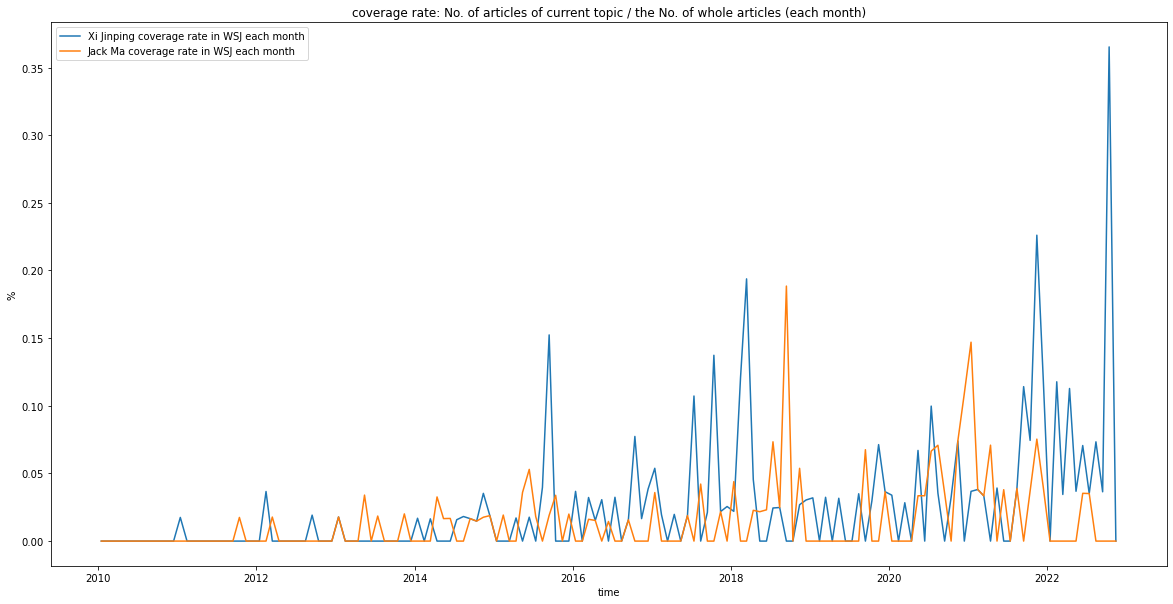

In [201]:
import datetime
import pandas as pd

# read csv file as dataframe, and remove NA rows
def read_data_by_year(year):
    df_data = pd.read_csv("C:/Users/Admin/Desktop/wsj_news" + str(year) + ".csv")
    L1 = len(df_data) # length before removing NA rows
    df_data=df_data.dropna()
    L2 = len(df_data) # length after removing NA rows
    df_data['time_str'] = df_data['news_date'].astype(str)
    df_data['time_str'] = df_data['time_str'].str[:10]
    df_data['topic_title'] = df_data['news_topic'].str.lower() + ":" + df_data['news_title'].str.lower()
    return df_data, L1, L2

# 
def search_for_year(df_data, kw="china"):
    L1 = len(df_data)
    tmp_df = df_data[ df_data['topic_title'].str.contains(kw.lower()) ]
    L2 = len(tmp_df)
    return L1, L2, round(L2*100.0/L1, 2)

# 
def search_for_month(year, kw="china"):
    df_data, L1, L2 = read_data_by_year(year)
    month_keyword = ['-01-', '-02-', '-03-', '-04-', '-05-', '-06-', '-07-', '-08-', '-09-', '-10-', '-11-', '-12-']
    rows = []
    for month in month_keyword:
        tmp_df = df_data[ df_data['time_str'].str.contains(month) ]
        L3 = len(tmp_df)
        tmp_df = tmp_df[ tmp_df['topic_title'].str.contains(kw.lower()) ]
        L4 = len(tmp_df)
        date_time = str(year) + month + "15"
        date_time = datetime.datetime.strptime(date_time, '%Y-%m-%d')
        rows.append( (year, L1, L2, date_time, L3, L4) ) # , round(L4*100.0/L3, 2)
    return df_data, rows

#
def search_for_day(year, kw="china"):
    df_data, L1, L2 = read_data_by_year(year)
    day_list = set( list( df_data['time_str'] ) )
    day_list = sorted(list(day_list))
    rows = []
    for day in day_list:
        tmp_df = df_data[ df_data['time_str']==day ]
        L3 = len(tmp_df)
        tmp_df = tmp_df[ tmp_df['topic_title'].str.contains(kw.lower()) ]
        L4 = len(tmp_df)
        date_time = datetime.datetime.strptime(day, '%Y-%m-%d')
        rows.append( (year, L1, L2, date_time, L3, L4) )
    return df_data, rows

#
def search_keyword_across_years(start_year=2008, end_year=2022, key_word="china", year_month_day=1, MA=1):
    x_axis, y_axis = [], []
    df_rows = []
    #
    for year in range(start_year, end_year):
        if year_month_day==1:
            df_data, L1, L2 = read_data_by_year(year)
            L2, L3, ratio = search_for_year(df_data, key_word)
            every_row = ( year, L1, L2, L3 )
            df_rows.append( every_row )
            WSJ_news_df = df_data.copy()
        elif year_month_day==2:
            df_data, rows = search_for_month(year, key_word)
            df_rows += rows
            WSJ_news_df = df_data.copy()
        elif year_month_day==3:
            #
            df_data, rows = search_for_day(year, key_word)
            df_rows += rows
            WSJ_news_df = df_data.copy()
    #
    tmp_label = ""
    if year_month_day==1:
        col_names = ['year', 'year_news', 'valid_year_news', 'year_kw_news'] #, 'year_kw_ratio'
        df_data = pd.DataFrame(df_rows, columns = col_names )
        df_data['ratio'] = df_data[col_names[-1]] / df_data[col_names[-2]] * 100
        feature1, feature2 = 'year', 'ratio'
        x_axis, y_axis = list( df_data[feature1] ), list(df_data[feature2])
        tmp_label = key_word+" coverage rate in WSJ each year"
    elif year_month_day==2:
        col_names = ['year', 'year_news', 'valid_year_news', 'month_time', 'month_news', 'month_kw_news'] #, 'month_kw_ratio'
        df_data = pd.DataFrame(df_rows, columns = col_names)
        df_data['month_news_ma'] = df_data['month_news'].rolling(MA).mean()
        df_data['month_kw_news_ma'] = df_data['month_kw_news'].rolling(MA).mean()
        df_data['ratio'] = df_data[col_names[-1]+"_ma"] / df_data[col_names[-2]+"_ma"] * 100
        feature1, feature2 = 'month_time', 'ratio'
        x_axis, y_axis = list( df_data[feature1] ), list(df_data[feature2])
        tmp_label = key_word+" coverage rate in WSJ each month"
    elif year_month_day==3:
        col_names = ['year', 'year_news', 'valid_year_news', 'day_time', 'day_news', 'day_kw_news'] 
        df_data = pd.DataFrame(df_rows, columns = col_names)
        df_data['day_news_ma'] = df_data['day_news'].rolling(MA).mean()
        df_data['day_kw_news_ma'] = df_data['day_kw_news'].rolling(MA).mean()
        df_data['ratio'] = df_data[col_names[-1]+"_ma"] / df_data[col_names[-2]+"_ma"] * 100
        feature1, feature2 = 'day_time', 'ratio'
        x_axis, y_axis = list( df_data[feature1] ), list(df_data[feature2])
        tmp_label = key_word+" coverage rate in WSJ each day"
    return WSJ_news_df, df_data, x_axis, y_axis, tmp_label


###
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))


start_year=2010
end_year=2023
kws = ['China', 'Japan', 'Australia', 'Hong Kong', 'Taiwan', 'Singapore', 'Canada']
kws = ['Xi Jinping', 'Jack Ma' ]
year_month_day = 2 # 1, 2, 3
time_range = {1:'year', 2:'month', 3:'day'}
MA=1
for key_word in kws[:]:
    WSJ_news_df, df_data, x_axis, y_axis, tmp_label = search_keyword_across_years(start_year, end_year, key_word, year_month_day, MA)
    plt.plot(x_axis, y_axis, label=tmp_label)


plt.title('coverage rate: No. of articles of current topic / the No. of whole articles (each ' + time_range[year_month_day] + ')')
plt.xlabel('time')
plt.ylabel('%')
#plt.bar(x_axis, y_axis, color ='b', width = 20, label="China coverage rate in WSJ each month") # , width = 0.4
plt.legend(fontsize = 10)
plt.show()